# Supervised Clustering of Computational Flow Dynamics for Aneurysms

#### Setup and Enviornment Configuration

Make sure the right library versions are used. SHAP may break with some versions of XGBoost (especially >= 2.x). Use `xgboost==1.6.2` and `shap==0.43.0` for compatibility with `TreeExplainer`.

In [47]:
import sklearn
import xgboost as xgb
import shap

In [48]:
print("Scikit-learn version:", sklearn.__version__)  # should be >= 1.0
print("XGBoost version:", xgb.__version__)  # recommended: 1.7.x or 1.6.x for SHAP compatibility
print("SHAP version:", shap.__version__)  # recommended: 0.41.x to 0.43.x for XGBoost

Scikit-learn version: 1.1.3
XGBoost version: 1.7.6
SHAP version: 0.43.0


##### Data Loading and Preprocessing

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

### Load the dataset
file_path = "Merged_Aneurysm.csv"
data = pd.read_csv(file_path)
data.head()


,case_id,patient_id,aneurysmLocation,aneurysmType,ruptureStatus,age,sex,multipleAneurysms,sacVolume,sacSurfaceArea,...,maxPressure,meanPressure,maxSpeed,meanSpeed,minTAWSS,maxTAWSS,meanTAWSS,minOSI,maxOSI,meanOSI
0,C0001,P0085,ICA,LAT,U,53,F,False,125.259604,120.453515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C0002,P0112,ICA,LAT,U,35,F,False,119.002032,122.427263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C0003,P0115,ICA,TER,U,43,F,False,12.740609,23.480617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C0004,P0116,ICA,TER,U,60,F,True,9.376307,18.084625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C0005,P0118,ICA,LAT,R,26,F,False,37.934454,54.844592,...,7665.0,3722.28,70.275319,13.19376,0.31251,176.44,20.90888,0.0,0.44672,0.001574


In [50]:
# Define the list of characteristics to be used
characteristics = [
    'age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea', 
    'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis', 
    'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength', 
    'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize', 
    'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star', 'sizeRatio_star', 
    'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle', 'meanRadius', 
    'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius', 'maxRadius', 
    'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane', 
    'bifurcationAngleOutOfPlane', 'aneurysmLocation', 'aneurysmType'
]

# Target Variable is Rupture Status, add to dataframe then segment to X and y
data_subset = data[characteristics + ['ruptureStatus']]

# Separate features and target variable
X = data_subset.drop(columns=['ruptureStatus'])
y = data_subset['ruptureStatus']

# Missing values handling
numerical_columns = X.select_dtypes(include=np.number).columns
categorical_columns = X.select_dtypes(exclude=np.number).columns

imputer_numerical = SimpleImputer(strategy='mean')
X[numerical_columns] = imputer_numerical.fit_transform(X[numerical_columns])

# Categorical columns handling
if not categorical_columns.empty:
    encoder = OneHotEncoder(drop='first', sparse=False)
    encoded_categorical = encoder.fit_transform(X[categorical_columns])
    encoded_categorical_columns = encoder.get_feature_names_out(categorical_columns)
    X = pd.concat([X.drop(columns=categorical_columns).reset_index(drop=True), 
                   pd.DataFrame(encoded_categorical, columns=encoded_categorical_columns)], axis=1)

# Target variable encoding
y_encoded = y.map({'R': 1, 'U': 0}).astype(int)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data preprocessing complete!")


Data preprocessing complete!


In [51]:
# mapping original values to encoding
mapping = {original: encoded for original, encoded in zip(y, y_encoded)}


print("Mapping of original labels to encoded values:")
# dataframe for mapping
mapping_df = pd.DataFrame({'Original': y, 'Encoded': y_encoded})
print(mapping_df)


Mapping of original labels to encoded values:
    Original  Encoded
0          U        0
1          U        0
2          U        0
3          U        0
4          R        1
..       ...      ...
98         U        0
99         R        1
100        R        1
101        R        1
102        U        0

[103 rows x 2 columns]


In [52]:
X.columns

Index(['age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation_BAS',
       'aneurysmLocation_ICA', 'aneurysmLocation_MCA', 'aneurysmType_TER'],
      dtype='object')

##### Model Training: XGBoost with GridSearch

Use `GridSearchCV` to tune hyperparameters and overfit the **entire** dataset to the XGBoost model 

In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                           param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_scaled, y_encoded)
xgb_model = grid_search.best_estimator_
xgb_model


`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecate

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

# GridSearchCV best model
best_model = grid_search.best_estimator_


y_pred_prob_best = cross_val_predict(best_model, X_scaled, y_encoded, cv=3, method='predict_proba')[:, 1]

# Calculate AUC-ROC for the best model
auc_roc_best = roc_auc_score(y_encoded, y_pred_prob_best)

# Print the best model's parameters and its AUC-ROC
print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Mean Cross-Validation Accuracy: {grid_search.best_score_:.3f}")
print(f"AUC-ROC Score: {auc_roc_best:.3f}")


`use_label_encoder` is deprecated in 1.7.0.


Best Model Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean Cross-Validation Accuracy: 0.709
AUC-ROC Score: 0.714


##### SHAP Transform

In [55]:
import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(xgb_model, X_scaled)

# Compute SHAP values
shap_values = explainer(X_scaled)

print("SHAP values computation complete!")


SHAP values computation complete!


##### Cluster SHAP transformed values

In [56]:
from umap.umap_ import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

# Dimensionality reduction using UMAP with fixed randomness
shap_2d = UMAP(n_components=2, n_neighbors=15, min_dist=0, random_state=42).fit_transform(shap_values.values)

# Clustering using HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
cluster_labels = hdbscan.fit_predict(shap_2d)

print("HDBSCAN Clustering complete!")


HDBSCAN Clustering complete!


n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


In [57]:
from sklearn.metrics import silhouette_score

score = silhouette_score(shap_2d, cluster_labels)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.8582625389099121


In [58]:
import pandas as pd

cluster_data = pd.DataFrame(shap_values.values, columns=X.columns)


label_mapping = {0: 'α', 1: 'β', 2: 'γ'}  # Cluster Mapping
cluster_labels = np.vectorize(label_mapping.get)(cluster_labels)
cluster_data['Cluster'] = cluster_labels
print(cluster_data.groupby('Cluster').mean())


              age  sacVolume  sacSurfaceArea  vdcVolume  vdcSurfaceArea  \
Cluster                                                                   
α       -0.024268        0.0             0.0   0.015644             0.0   
β        0.002909        0.0             0.0   0.004815             0.0   
γ        0.003593        0.0             0.0  -0.007287             0.0   

         sacSectionArea  ellipsoidVolume  ellipsoidMaxSemiaxis  \
Cluster                                                          
α             -0.110991        -0.079248              0.010991   
β              0.003858        -0.000735              0.004135   
γ              0.040285         0.026342             -0.004615   

         ellipsoidMidSemiaxis  ellipsoidMinSemiaxis  ...  minRadius  \
Cluster                                              ...              
α                   -0.132224                   0.0  ...  -0.072936   
β                    0.013414                   0.0  ...   0.203433   
γ        

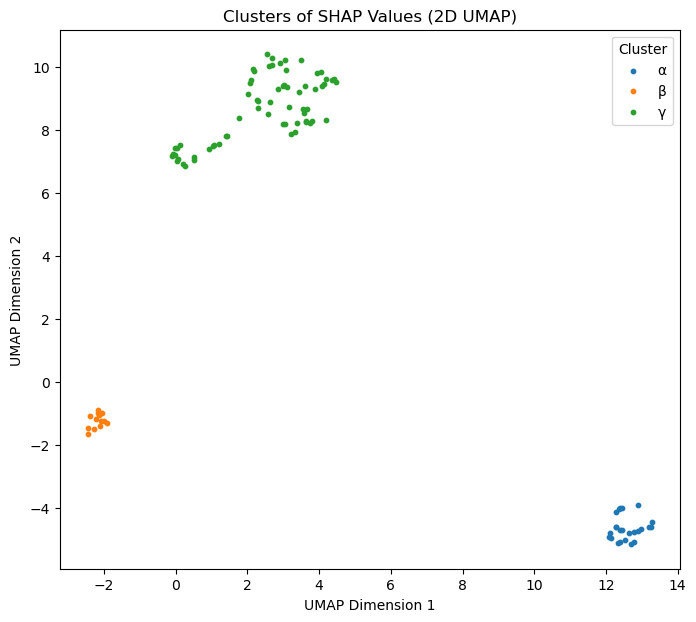

In [59]:
# Visualize Clusters
plt.figure(figsize=(8, 7))
for cluster in np.unique(cluster_labels):
    indices = cluster_labels == cluster
    plt.scatter(
        shap_2d[indices, 0],
        shap_2d[indices, 1],
        label=cluster,
        s=10
    )
plt.title("Clusters of SHAP Values (2D UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster")
plt.show()

##### Cluster Analysis

In [60]:
import pandas as pd

# SHAP Values Dataframe with cluster values
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df['Cluster'] = cluster_labels

# Group by clusters and calculate mean SHAP values
cluster_means = shap_df.groupby('Cluster').mean()

# top SHAP features per cluster
print(cluster_means.T)


Cluster                            α         β         γ
age                        -0.024268  0.002909  0.003593
sacVolume                   0.000000  0.000000  0.000000
sacSurfaceArea              0.000000  0.000000  0.000000
vdcVolume                   0.015644  0.004815 -0.007287
vdcSurfaceArea              0.000000  0.000000  0.000000
sacSectionArea             -0.110991  0.003858  0.040285
ellipsoidVolume            -0.079248 -0.000735  0.026342
ellipsoidMaxSemiaxis        0.010991  0.004135 -0.004615
ellipsoidMidSemiaxis       -0.132224  0.013414  0.039878
ellipsoidMinSemiaxis        0.000000  0.000000  0.000000
sacCenterlineLength         0.013925  0.004591 -0.005360
ostiumSectionArea           0.000000  0.000000  0.000000
ostiumSectionPerimeter      0.001244  0.002344 -0.000937
ostiumMinSize              -0.025742  0.041647  0.003590
ostiumMaxSize               0.000000  0.000000  0.000000
ostiumShapeFactor          -0.004458  0.005847  0.002674
aspectRatio_star           -0.0

In [61]:
import pandas as pd
from scipy.stats import chi2_contingency

# Cluster and rupture status data
cluster_df = pd.DataFrame({
    'Cluster': cluster_labels,
    'RuptureStatus': y_encoded  
})

# rupture proportions by cluster with chi-squared test
rupture_distribution = cluster_df.groupby('Cluster')['RuptureStatus'].mean()
cluster_sizes = cluster_df.groupby('Cluster')['RuptureStatus'].size()


contingency_table = pd.crosstab(cluster_df['Cluster'], cluster_df['RuptureStatus'])


chi2, p_value, dof, expected = chi2_contingency(contingency_table)

rupture_distribution, cluster_sizes, p_value


(Cluster
 α    0.041667
 β    1.000000
 γ    0.454545
 Name: RuptureStatus, dtype: float64,
 Cluster
 α    24
 β    13
 γ    66
 Name: RuptureStatus, dtype: int64,
 1.0127791801877694e-07)

In [62]:
from scipy.stats import chi2_contingency, fisher_exact
from itertools import combinations

# Unique cluster pairs
cluster_pairs = list(combinations(cluster_df['Cluster'].unique(), 2))

# Pairwise comparisons (fisher's exact test or chi-squared test) with Bonferroni correction
results = []
for c1, c2 in cluster_pairs:
    sub_table = pd.crosstab(
        cluster_df[cluster_df['Cluster'].isin([c1, c2])]['Cluster'],
        cluster_df[cluster_df['Cluster'].isin([c1, c2])]['RuptureStatus']
    )
    if sub_table.values.min() < 5:  # Use Fisher's Exact Test for small counts
        _, p_value = fisher_exact(sub_table)
        test_type = "Fisher"
    else:  # Use Chi-Square for larger counts
        _, p_value, _, _ = chi2_contingency(sub_table)
        test_type = "Chi-Square"
    results.append({'Cluster Pair': (c1, c2), 'p-value': p_value, 'Test': test_type})

bonferroni_alpha = 0.05 / len(results)  

# Output 
for result in results:
    result['Significant'] = result['p-value'] < bonferroni_alpha
    print(result)


{'Cluster Pair': ('α', 'γ'), 'p-value': 0.00012938965419534264, 'Test': 'Fisher', 'Significant': True}
{'Cluster Pair': ('α', 'β'), 'p-value': 3.929860633387428e-09, 'Test': 'Fisher', 'Significant': True}
{'Cluster Pair': ('γ', 'β'), 'p-value': 0.00014734260135082858, 'Test': 'Fisher', 'Significant': True}


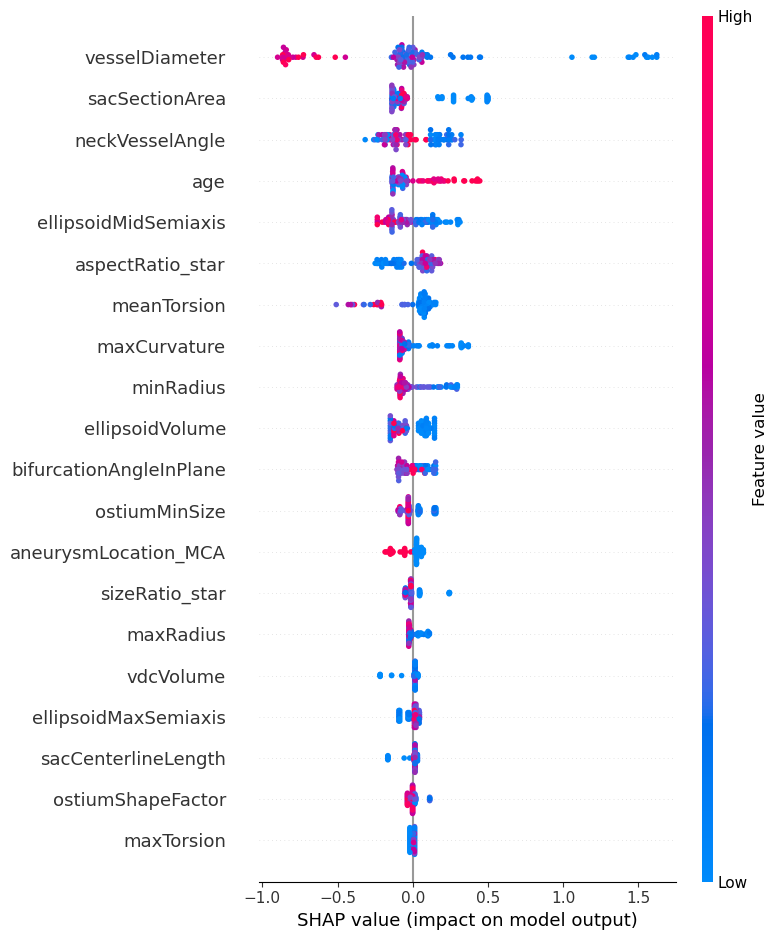

In [63]:
import shap
# SHAP summary plot
shap.summary_plot(shap_values.values, features=X_scaled, feature_names=X.columns)


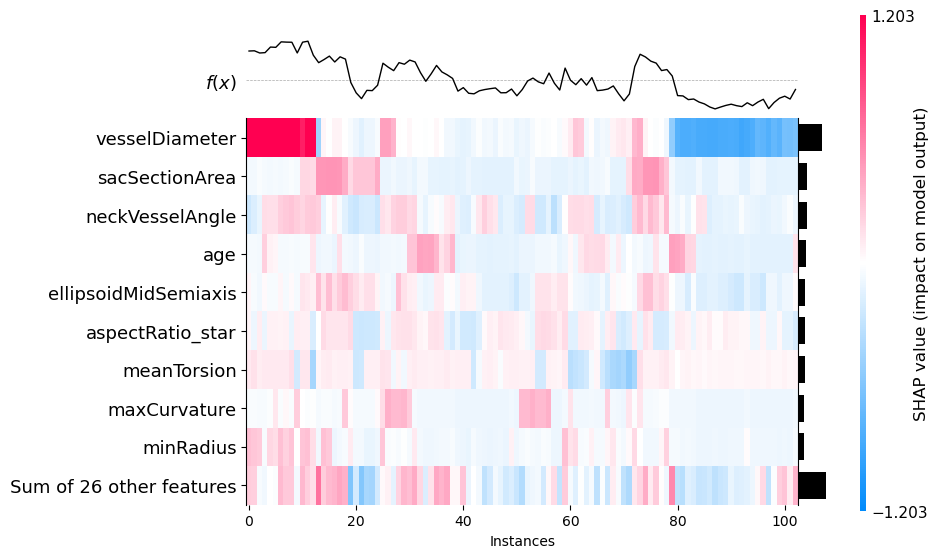

In [64]:
explainer = shap.Explainer(xgb_model, X_scaled, feature_names=X.columns)
shap_values = explainer(X_scaled)
# SHAP Heatmap
shap.plots.heatmap(shap_values)


In [65]:
'''# Mean SHAP values by cluster
cluster_summary = cluster_data.groupby('Cluster').mean()
print(cluster_summary)
'''

"# Mean SHAP values by cluster\ncluster_summary = cluster_data.groupby('Cluster').mean()\nprint(cluster_summary)\n"

In [66]:
'''# Add cluster labels to the original dataset
original_data = data[characteristics].copy()
original_data['Cluster'] = cluster_labels

# Select only numeric columns
numeric_columns = original_data.select_dtypes(include=np.number)

# Calculate mean feature values for each cluster (true values)
true_cluster_summary = numeric_columns.groupby(original_data['Cluster']).mean()

# Display the mean true values by cluster
print(true_cluster_summary)
'''

"# Add cluster labels to the original dataset\noriginal_data = data[characteristics].copy()\noriginal_data['Cluster'] = cluster_labels\n\n# Select only numeric columns\nnumeric_columns = original_data.select_dtypes(include=np.number)\n\n# Calculate mean feature values for each cluster (true values)\ntrue_cluster_summary = numeric_columns.groupby(original_data['Cluster']).mean()\n\n# Display the mean true values by cluster\nprint(true_cluster_summary)\n"

In [67]:
# Overfitted model performance per cluster (sanity check)
cluster_df['Prediction'] = xgb_model.predict(X_scaled)
cluster_accuracy = cluster_df.groupby('Cluster').apply(lambda x: (x['Prediction'] == x['RuptureStatus']).mean())
print(cluster_accuracy)


Cluster
α    0.958333
β    1.000000
γ    0.954545
dtype: float64


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [68]:
import shap
import seaborn as sns
shap.initjs()

# Force plot for the first 1000 samples
original_values = scaler.inverse_transform(X_scaled[:1000])

shap.force_plot(
    explainer.expected_value,
    shap_values.values[:1000],
    original_values,
    feature_names=X.columns
)

# Save the force plot (.html file)
shap.save_html('force_plot.html', shap.force_plot(
    explainer.expected_value,
    shap_values.values[:1000],
    original_values,
    feature_names=X.columns
))


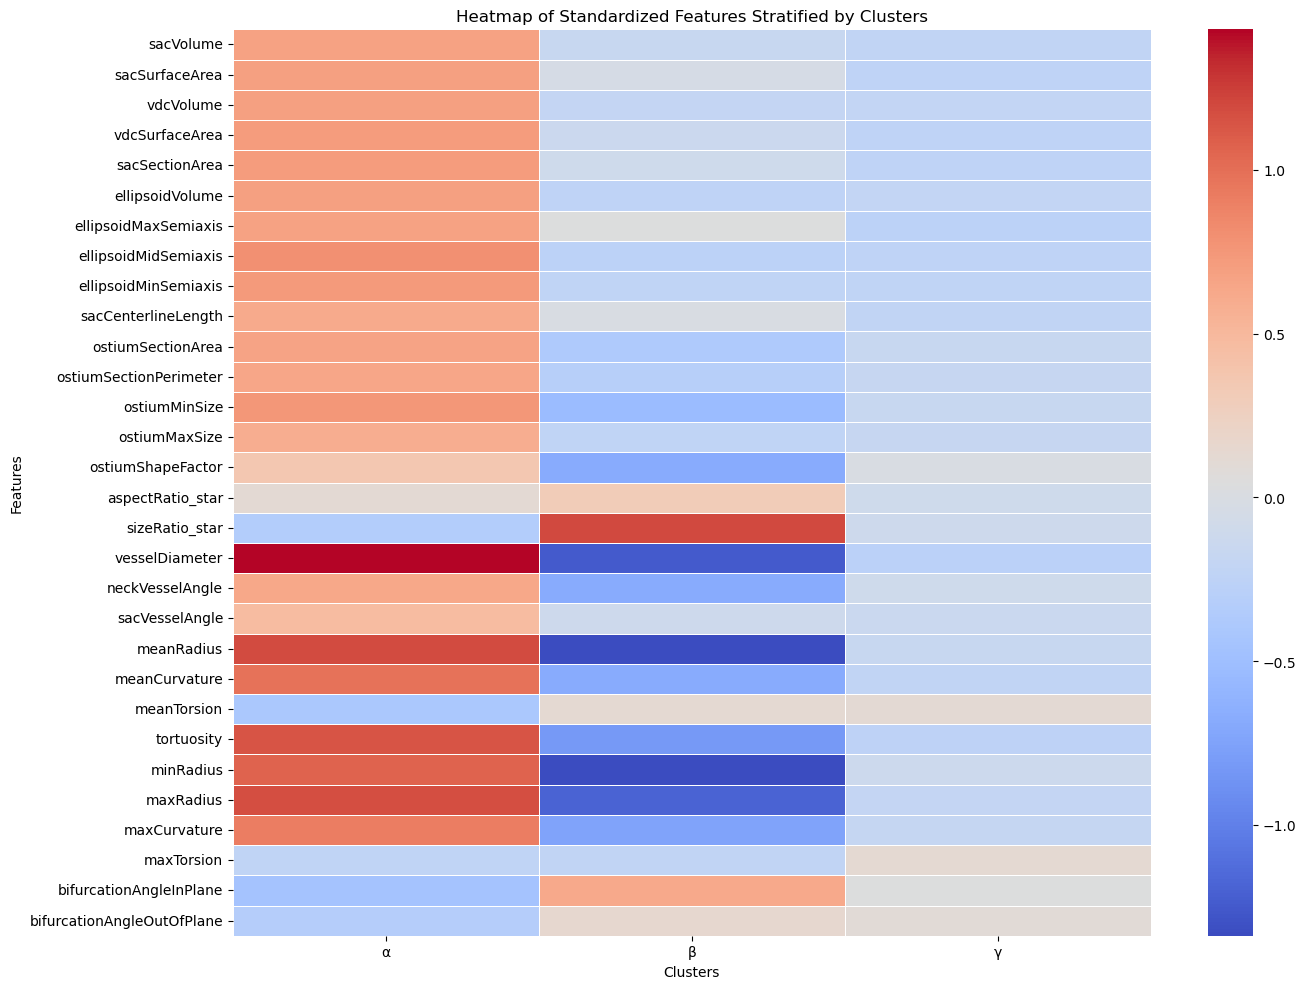

In [69]:
# Features per cluster
original_data = data[characteristics].copy()
original_data['Cluster'] = cluster_labels

numeric_features_filtered = original_data.drop(columns=['Cluster', 'aneurysmLocation', 'aneurysmType', 'age'])

# Standardize
standardized_features_filtered = pd.DataFrame(
    scaler.fit_transform(numeric_features_filtered),
    columns=numeric_features_filtered.columns
)

standardized_features_filtered['Cluster'] = original_data['Cluster']

# Mean of each feature grouped by cluster
cluster_feature_means_filtered = standardized_features_filtered.groupby('Cluster').mean().T

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_feature_means_filtered, cmap='coolwarm', annot=False, cbar=True, linewidths=0.5)
plt.title("Heatmap of Standardized Features Stratified by Clusters")
plt.xlabel("Clusters")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [70]:
X.columns

Index(['age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation_BAS',
       'aneurysmLocation_ICA', 'aneurysmLocation_MCA', 'aneurysmType_TER'],
      dtype='object')

##### Dependence Plot Analysis

In [71]:
# Postprocessing for Dependence plot analysis 
X['aneurysmLocation'] = data['aneurysmLocation']
X['aneurysmType'] = data['aneurysmType']


X = X.drop(columns=['aneurysmLocation_BAS', 'aneurysmLocation_ICA'])

print(X.columns)


Index(['age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation_MCA',
       'aneurysmType_TER', 'aneurysmLocation', 'aneurysmType'],
      dtype='object')


**Vessel Diameter** 

The red points in the SHAP dependence plot correspond to the aneurysm type with the lower mean vesselDiameter, which is TER.
The blue points correspond to the aneurysm type with the higher mean vesselDiameter, which is LAT.

aneurysmType

 LAT    3.251116
 
 TER    1.892105

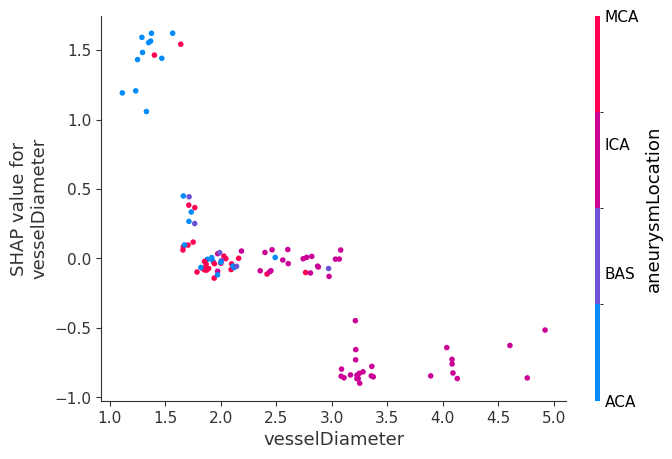

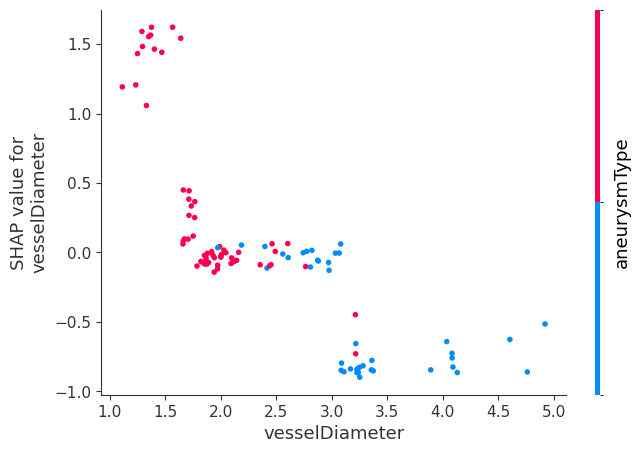

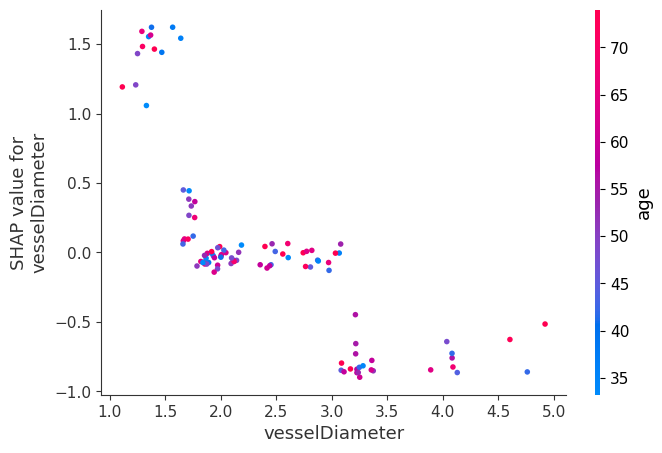

In [72]:
shap.dependence_plot('vesselDiameter', shap_values.values, X, interaction_index='aneurysmLocation', feature_names=X.columns)
shap.dependence_plot('vesselDiameter', shap_values.values, X, interaction_index='aneurysmType', feature_names=X.columns)
shap.dependence_plot('vesselDiameter', shap_values.values, X, interaction_index='age', feature_names=X.columns)


**Neck Vessel Angle** 

The red points in the SHAP dependence plot correspond to the aneurysm type with the lower mean vesselDiameter, which is TER.
The blue points correspond to the aneurysm type with the higher mean vesselDiameter, which is LAT.

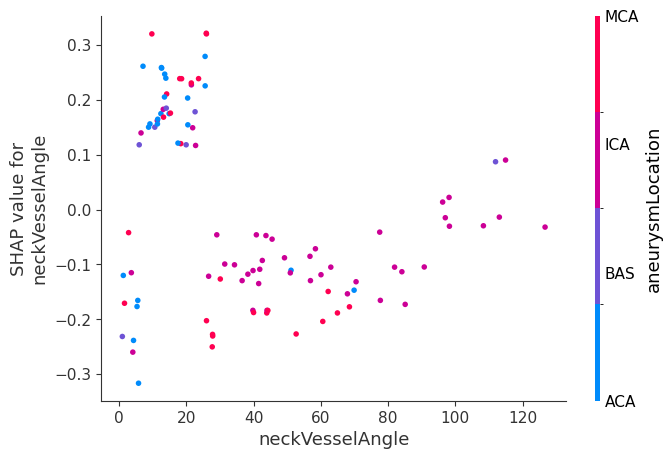

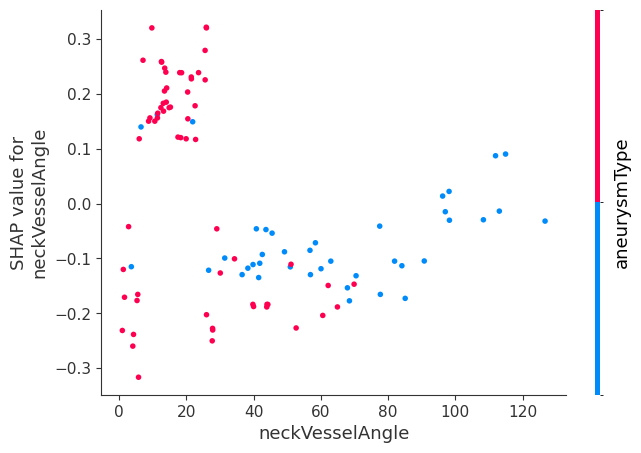

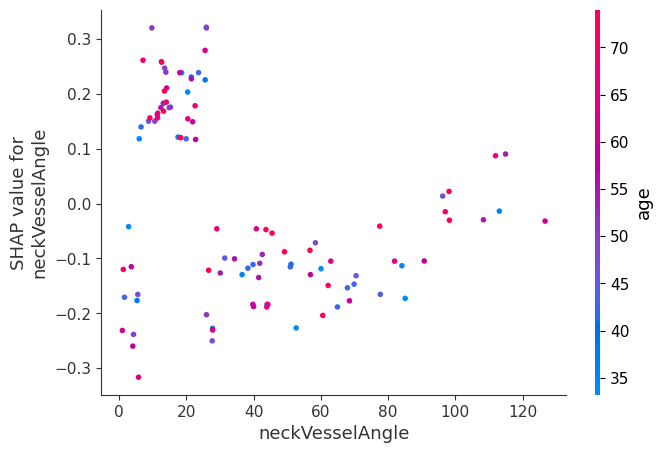

In [73]:
shap.dependence_plot('neckVesselAngle', shap_values.values, X, interaction_index='aneurysmLocation', feature_names=X.columns)
shap.dependence_plot('neckVesselAngle', shap_values.values, X, interaction_index='aneurysmType', feature_names=X.columns)
shap.dependence_plot('neckVesselAngle', shap_values.values, X, interaction_index='age', feature_names=X.columns)


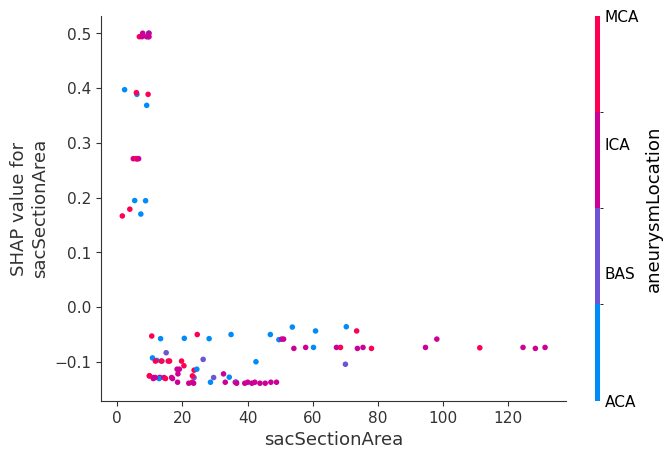

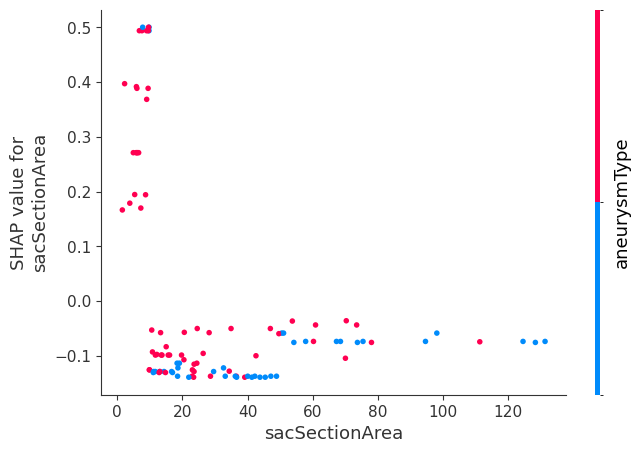

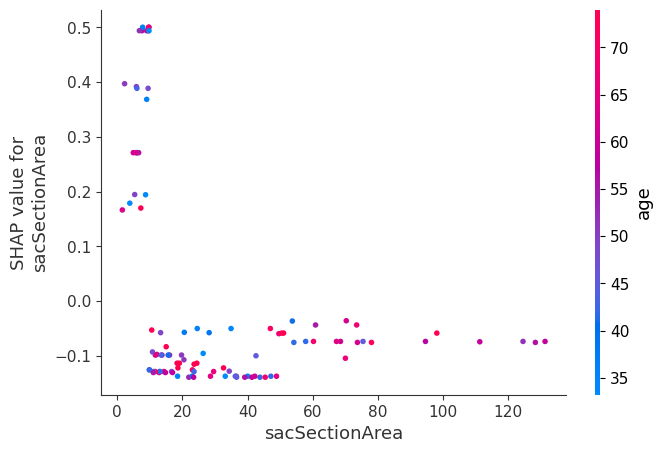

In [74]:
shap.dependence_plot('sacSectionArea', shap_values.values, X, interaction_index='aneurysmLocation', feature_names=X.columns)
shap.dependence_plot('sacSectionArea', shap_values.values, X, interaction_index='aneurysmType', feature_names=X.columns)
shap.dependence_plot('sacSectionArea', shap_values.values, X, interaction_index='age', feature_names=X.columns)


In [75]:
X.columns

Index(['age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation_MCA',
       'aneurysmType_TER', 'aneurysmLocation', 'aneurysmType'],
      dtype='object')

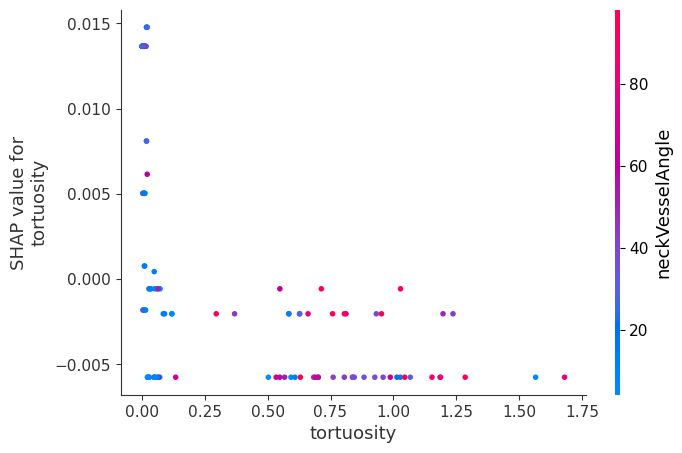

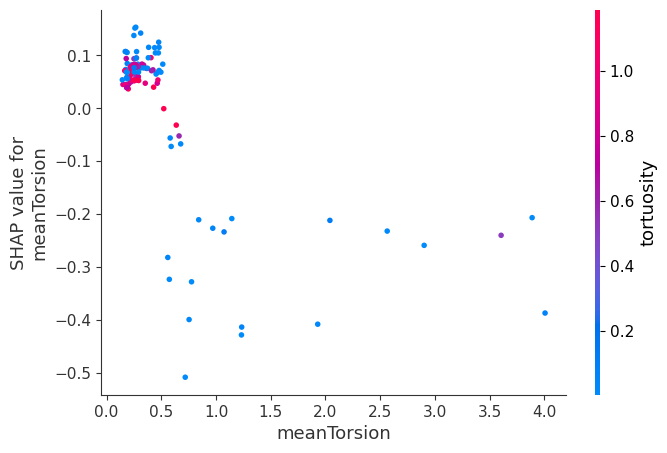

In [76]:
shap.dependence_plot('tortuosity', shap_values.values, X, interaction_index='neckVesselAngle', feature_names=X.columns)
shap.dependence_plot('meanTorsion', shap_values.values, X, interaction_index='tortuosity', feature_names=X.columns)


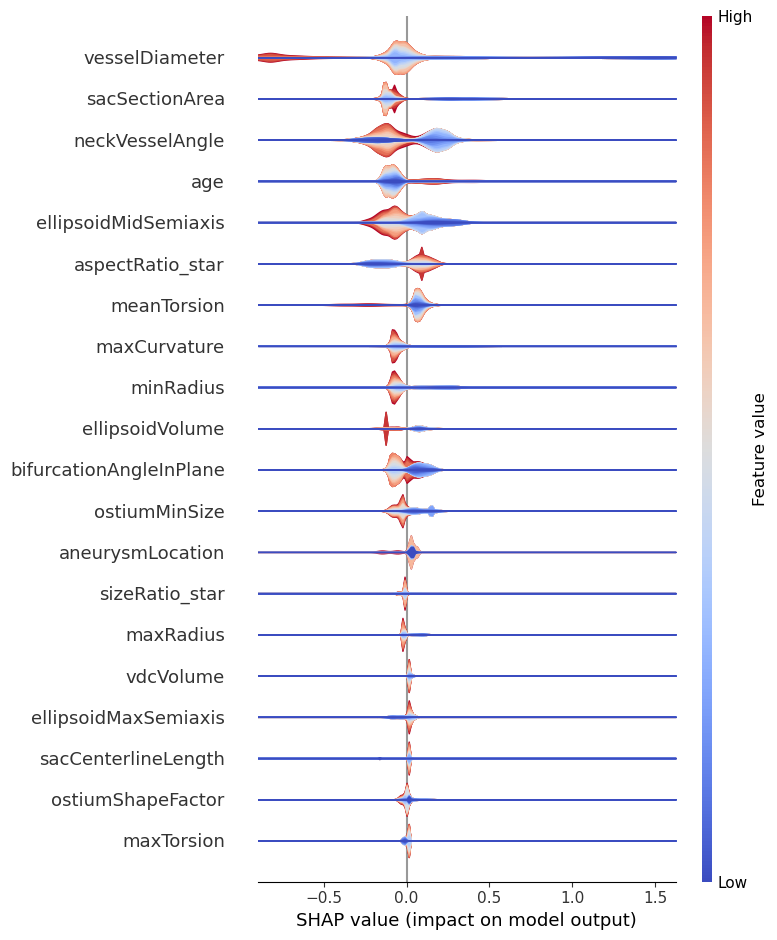

In [77]:
# Summary Plot, Finalized
shap.summary_plot(shap_values.values, features=X, feature_names=X.columns, plot_type="layered_violin")


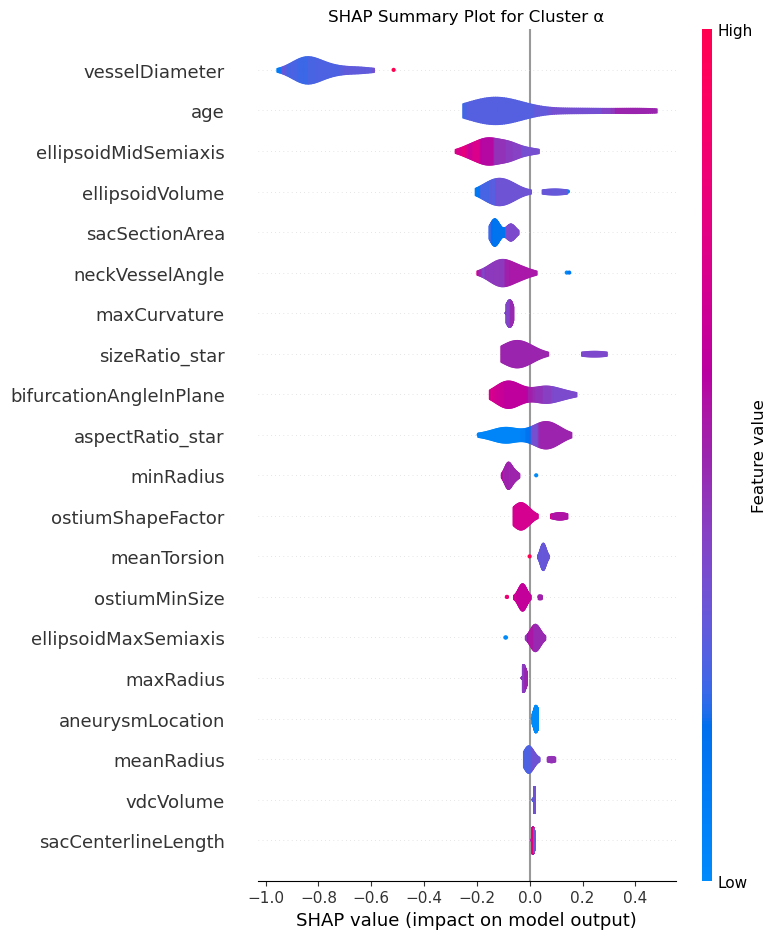

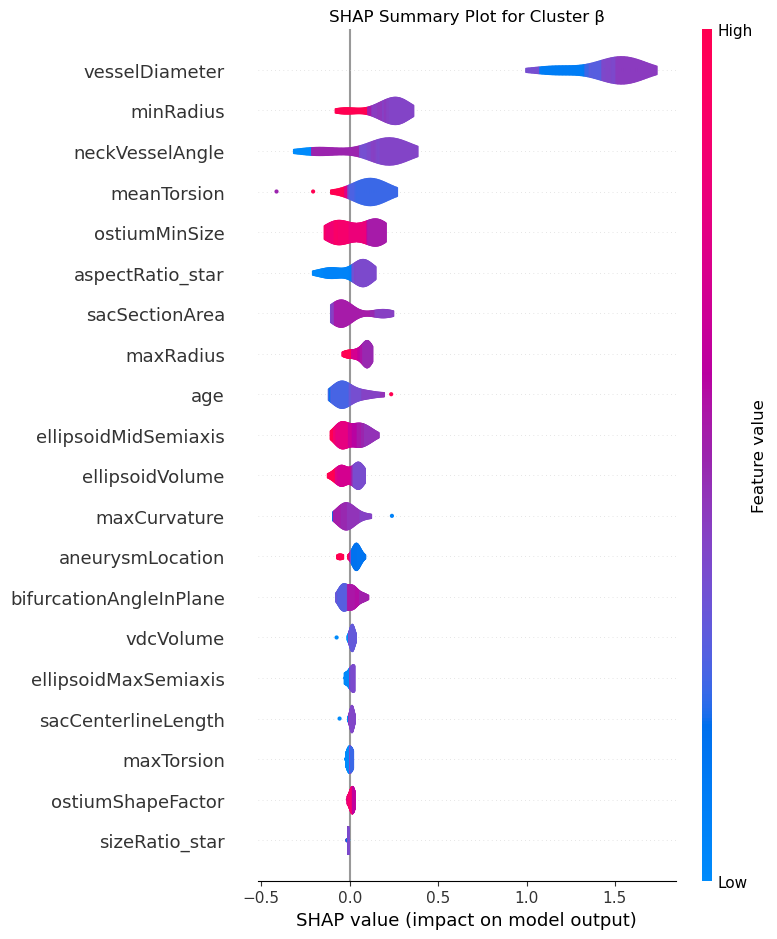

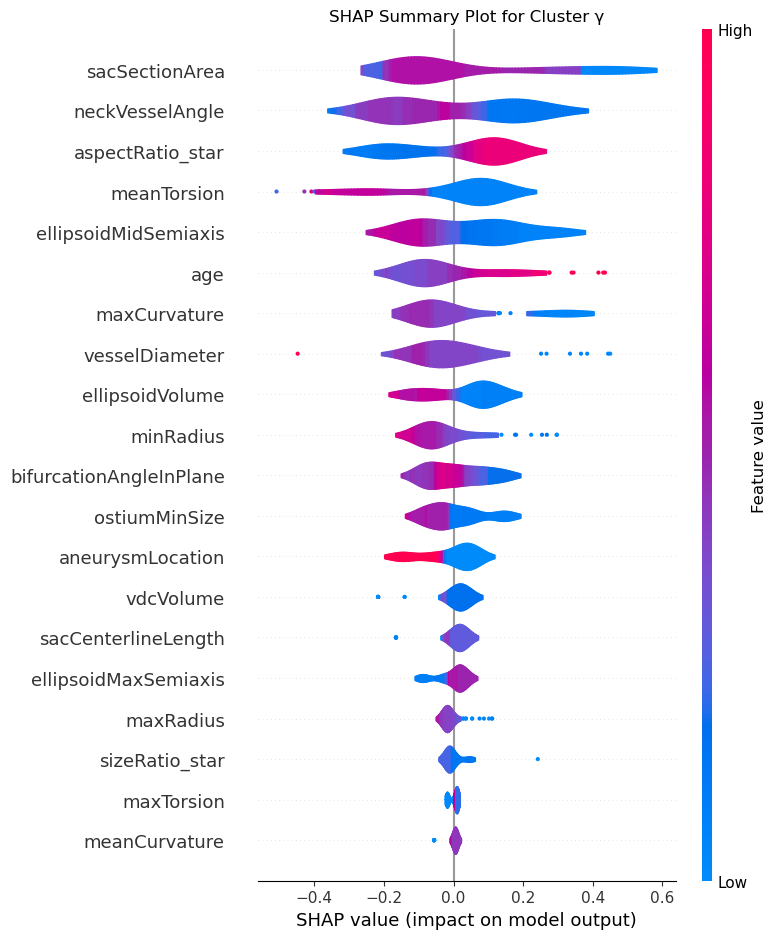

In [78]:
import shap
import matplotlib.pyplot as plt

# Summary Plot PER cluster
def plot_shap_summary_for_cluster(cluster_label, X_scaled, cluster_labels, shap_values, feature_names):
    cluster_indices = (cluster_labels == cluster_label)
    X_cluster = X_scaled[cluster_indices]
    shap_values_cluster = shap_values[cluster_indices]

    plt.title(f"SHAP Summary Plot for Cluster {cluster_label}")
    shap.summary_plot(shap_values_cluster, X_cluster, feature_names=feature_names, plot_type="violin")

for cluster in sorted(set(cluster_labels)):
    plot_shap_summary_for_cluster(cluster, X_scaled, cluster_labels, shap_values.values, feature_names=X.columns)


##### Rule-Based Learning

In [ ]:
from skrules import SkopeRules
from sklearn.impute import SimpleImputer
import re

# Postprocess dataframe for rule-based ML
original_data = data[characteristics].copy()
original_data['Cluster'] = cluster_labels

numeric_columns = original_data.select_dtypes(include=np.number).columns
numeric_data = original_data[numeric_columns]


numeric_data['Cluster'] = cluster_labels
imputer = SimpleImputer(strategy='mean')  

numeric_data_imputed = pd.DataFrame(
    imputer.fit_transform(numeric_data.drop(columns='Cluster')),
    columns=numeric_data.columns.drop('Cluster')
)

numeric_data_imputed['Cluster'] = cluster_labels


# Generate rules for each cluster
rules_per_cluster = {}

# Loop through each cluster to generate rules
for cluster in np.unique(cluster_labels):
    print(f"Generating rules for Cluster {cluster}...")
    
    numeric_data_imputed['IsCluster'] = (numeric_data_imputed['Cluster'] == cluster).astype(int)
    
    skope = SkopeRules(max_depth=2, n_estimators=30, precision_min=0.5)
    skope.fit(numeric_data_imputed.drop(columns=['Cluster', 'IsCluster']), numeric_data_imputed['IsCluster'])
    
    rules = skope.rules_
    rules_per_cluster[cluster] = rules



# feature mapping
feature_map = {
    "__C__0": "age",
    "__C__1": "sacVolume",
    "__C__2": "sacSurfaceArea",
    "__C__3": "vdcVolume",
    "__C__4": "vdcSurfaceArea",
    "__C__5": "sacSectionArea",
    "__C__6": "ellipsoidVolume",
    "__C__7": "ellipsoidMaxSemiaxis",
    "__C__8": "ellipsoidMidSemiaxis",
    "__C__9": "ellipsoidMinSemiaxis",
    "__C__10": "sacCenterlineLength",
    "__C__11": "ostiumSectionArea",
    "__C__12": "ostiumSectionPerimeter",
    "__C__13": "ostiumMinSize",
    "__C__14": "ostiumMaxSize",
    "__C__15": "ostiumShapeFactor",
    "__C__16": "aspectRatio_star",
    "__C__17": "sizeRatio_star",
    "__C__18": "vesselDiameter",
    "__C__19": "neckVesselAngle",
    "__C__20": "sacVesselAngle",
    "__C__21": "meanRadius",
    "__C__22": "meanCurvature",
    "__C__23": "meanTorsion",
    "__C__24": "tortuosity",
    "__C__25": "minRadius",
    "__C__26": "maxRadius",
    "__C__27": "maxCurvature",
    "__C__28": "maxTorsion",
    "__C__29": "bifurcationAngleInPlane",
    "__C__30": "bifurcationAngleOutOfPlane"
}

def replace_placeholders(rule, feature_map):
    condition, stats = rule
    for placeholder, feature_name in feature_map.items():
        condition = re.sub(rf'\b{re.escape(placeholder)}\b', feature_name, condition)
    return f"{condition} (Support: {stats[2]}, Precision: {stats[0]}, Recall: {stats[1]})"


for cluster, rules in rules_per_cluster.items():
    print(f"\nCluster {cluster} Mapped Rules:")
    for rule in rules:
        print(replace_placeholders(rule, feature_map))




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Generating rules for Cluster α...
Generating rules for Cluster β...
Generating rules for Cluster γ...

Cluster α Mapped Rules:
vesselDiameter > 3.083630681037903 and ellipsoidMaxSemiaxis > 1.8040499687194824 (Support: 5, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.0852437019348145 and vdcVolume > 22.96495819091797 (Support: 2, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidVolume > 16.73472023010254 (Support: 4, Precision: 1.0, Recall: 1.0)
ostiumSectionPerimeter > 10.196825981140137 and vesselDiameter > 3.0852437019348145 (Support: 1, Precision: 1.0, Recall: 1.0)
sacVolume > 25.015841484069824 and vesselDiameter > 3.083630681037903 (Support: 2, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and sacSurfaceArea > 40.92924499511719 (Support: 1, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and sacSurfaceArea > 36.96127891540527 (Support: 1, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidMid

In [80]:
# Rank rules by precision and support
ranked_rules = {}

for cluster, rules in rules_per_cluster.items():   
    ranked_rules[cluster] = sorted(
        rules, key=lambda x: (x[1][0], x[1][2]), reverse=True  
    )

for cluster, rules in ranked_rules.items():
    print(f"\nTop Rules for Cluster {cluster}:")
    for rule in rules[:5]:  
        print(replace_placeholders(rule, feature_map))



Top Rules for Cluster α:
vesselDiameter > 3.083630681037903 and ellipsoidMaxSemiaxis > 1.8040499687194824 (Support: 5, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidVolume > 16.73472023010254 (Support: 4, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidMidSemiaxis > 1.6103500127792358 (Support: 3, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.0852437019348145 and vdcVolume > 22.96495819091797 (Support: 2, Precision: 1.0, Recall: 1.0)
sacVolume > 25.015841484069824 and vesselDiameter > 3.083630681037903 (Support: 2, Precision: 1.0, Recall: 1.0)

Top Rules for Cluster β:
vesselDiameter <= 1.650891900062561 (Support: 32, Precision: 1.0, Recall: 1.0)
vesselDiameter <= 1.6143537163734436 (Support: 13, Precision: 1.0, Recall: 0.9178710178710179)
vesselDiameter <= 1.6526591777801514 (Support: 8, Precision: 1.0, Recall: 1.0)
vesselDiameter <= 1.616120994091034 (Support: 4, Precision: 1.0, Recall: 0.9087121212121212)
vesselDiameter 